In [148]:
import pandas as pd
import numpy as np
import os
import glob
import netCDF4 as nc
import matplotlib.pyplot as plt
import seaborn
from scipy.spatial.distance import cdist
import cartopy.crs as ccrs
import cartopy.feature as cf
from functions.fun_sdk import *

os.environ['TZ'] = 'UTC'

In [102]:
sed = ['2021-06-01','2021-06-02','2021-06-04','2021-06-05','2021-06-08','2021-06-18','2021-06-21','2021-06-22','2021-07-13','2021-07-25','2021-07-26']

cell_occ = pd.DataFrame() # Dataframe for lifetime
cvelo = pd.DataFrame() # Dataframe for cell velocity


for i in np.arange(0,len(sed),1):
    doi = sed[i]
    y_oi = doi.split('-')[0]
    m_oi = doi.split('-')[1]
    d_oi = doi.split('-')[2]

    fs = glob.glob("/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tracks/data/"+y_oi+"/"+m_oi+"/"+d_oi+"/UTM_*")

    for k in np.arange(0,len(fs),1):
        data = pd.read_csv(fs[k])
        # get regular time interval (should be 5 minutes for SEVIRI rapid scan)
        ts = np.arange(1,len(data.time.unique()),1)
        for i in np.arange(1,len(data.time.unique()),1):
            ts[i-1] = data.time.unique()[i]-data.time.unique()[i-1]
        ts = 300 * round(ts.mean()/300)/60

        ##################
        # CELL LIFETIMES #
        ##################
        # calculate life time (minutes)
        temp_row = pd.DataFrame([{'cellID':data.cell[0], 'occ':ts*len(data)-ts}])
        cell_occ = pd.concat([cell_occ,temp_row],axis=0)
        cell_occ = cell_occ.reset_index(drop=True)

        #################
        # CELL VELOCITY #
        #################

        velocity = pd.DataFrame({'velocity':np.arange(1,len(data),1).astype(float)})
        for i in np.arange(1,len(data),1):
            ydist = data.hdim_1[i]-data.hdim_1[i-1] # distance along latitude in km
            xdist = data.hdim_2[i]-data.hdim_2[i-1] # distance along longitude in km

            dist = np.sqrt(xdist**2+ydist**2)*550 # distance in m
            velocity.velocity[i-1] = dist/(ts*60)

        cvelocity = pd.concat([pd.DataFrame({'cell':np.repeat(data.cell[0],len(data)-1), 'timestr':list(data.timestr.loc[1:len(data)])}),velocity],axis=1)
        cvelo = pd.concat([cvelo,cvelocity], axis = 0)
        cvelo = cvelo.reset_index(drop=True)

/Users/nicobader/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nicobader/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparency" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app
/Users/nicobader/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histo

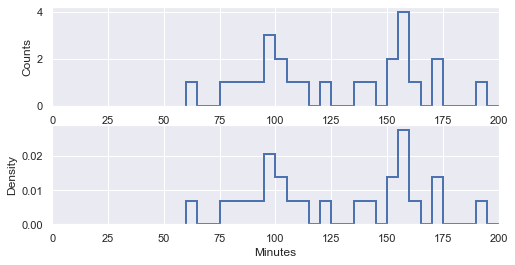

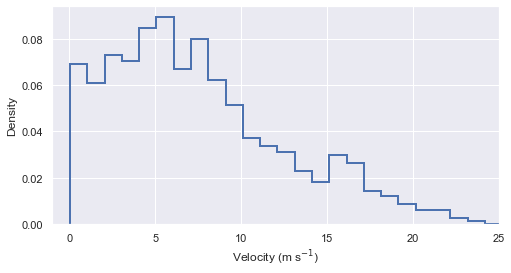

In [107]:
# Plot the cell lifetimes
# Histogram
fig, (ax1, ax2) = plt.subplots(2, figsize = (8,4))
#fig.suptitle('Vertically stacked subplots')
ax1.hist(cell_occ.occ,histtype='step', linewidth = 2, bins = int((cell_occ.occ.max()-cell_occ.occ.min())/ts))
ax1.set_xlim(0,200)
ax1.set_ylabel('Counts')

# Probability density function (PDF)
seaborn.distplot(cell_occ.occ,kde = True, hist = True, hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1}, kde_kws={'linewidth':0}, bins = int((cell_occ.occ.max()-cell_occ.occ.min())/ts))
ax2.set_xlim(0,200)
ax2.set_xlabel('Minutes')
ax2.set_ylabel('Density')
#plt.show()
plt.savefig("/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/cell_lifetimes.png", dpi = 400, facecolor = 'white', transparency = False)

plt.figure(figsize=(8,4))
seaborn.distplot(cvelo.velocity,kde = True, hist = True, hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1}, kde_kws={'linewidth':0}, bins = int((cvelo.velocity.max()-cvelo.velocity.min())))
plt.xlim(-1,25) # higher cell velocities due to manually track changes
plt.xlabel('Velocity (m s$^{-1}$)')
plt.ylabel('Density')
#plt.show()
plt.savefig("/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/cell_velocity.png", dpi = 400, facecolor = 'white', transparency = False)

In [108]:
# Get NWP model data for the tracks
# Complete time scale
# Surface parameters
nwp = 'ERA5T'
sed = ['2021-06-01','2021-06-02','2021-06-04','2021-06-05','2021-06-08','2021-06-18','2021-06-21','2021-06-22','2021-07-13','2021-07-25','2021-07-26']

cellsmeteo = pd.DataFrame() # Dataframe for meteo of single cell

for i in np.arange(0,len(sed),1):
    doi = sed[i]
    y_oi = doi.split('-')[0]
    m_oi = doi.split('-')[1]
    d_oi = doi.split('-')[2]

    fs = glob.glob("/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tracks/data/"+y_oi+"/"+m_oi+"/"+d_oi+"/Track_*")

    for j in np.arange(0,len(fs),1):
        cdata = pd.read_csv(fs[j])

        meteo = pd.DataFrame()
        for k in np.arange(0,len(cdata),1):
            start = cdata.timestr[k].split()[0]
            end = cdata.timestr[k].split()[0]

            time = pd.Timestamp(cdata.timestr[k]).round('1 H')

            cois = [[cdata.longitude[k],cdata.latitude[k]]]

            nwpdata = get_surface_model_output(cois, start, end, nwp, apikey='nRMiXJ34HBIwOjlq')

            nwpdata = nwpdata[nwpdata.TIMESTAMP == time]
            nwpdata = nwpdata.iloc[:,3:8]

            meteo = pd.concat([meteo, nwpdata],axis = 0)
            meteo = meteo.reset_index(drop = True)
        meteo = pd.concat([cdata[['timestr','cell']],meteo], axis = 1)
        cellsmeteo = pd.concat([cellsmeteo,meteo],axis=0)

# save to csv
# cellsmeteo.to_csv("/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/data/track_statistic_surface.csv", index=False)

In [149]:
cellsmeteo = pd.read_csv("/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/data/track_statistic_surface.csv")

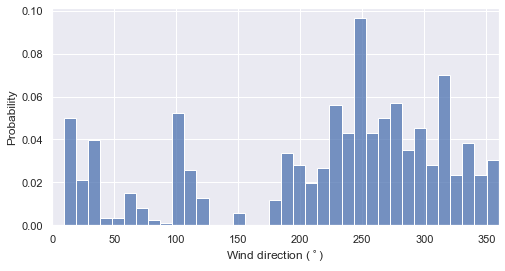

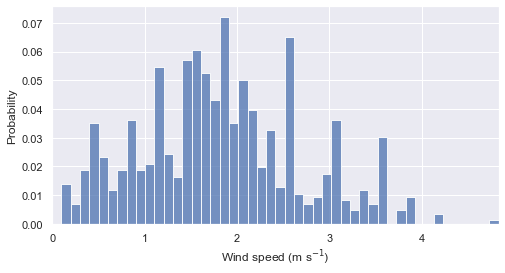

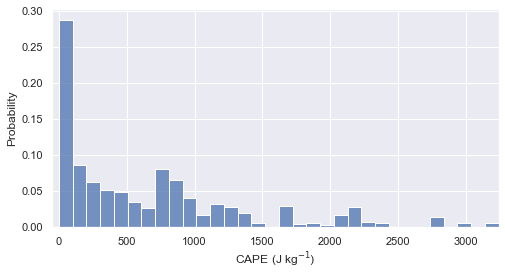

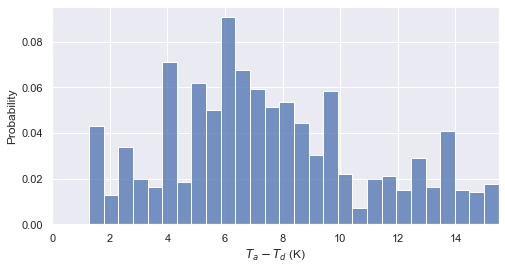

In [150]:
# WIND DIRECTION
plt.figure(figsize=(8,4))
seaborn.histplot(cellsmeteo.winddir, kde = False, stat = 'probability', bins = 36)
plt.xlabel('Wind direction ($^\circ$)')
#plt.ylabel('Density')
plt.xlim(0,360)
plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/surface_tALL_wind_direction_'+nwp+'.png',dpi=400,facecolor='white',transparent=False)

# WIND SPEED
plt.figure(figsize=(8,4))
seaborn.histplot(cellsmeteo.windspeed/3.6, kde = False, stat = 'probability', bins = int(((cellsmeteo.windspeed/3.6).max()-(cellsmeteo.windspeed/3.6).min())/0.1))
plt.xlabel('Wind speed (m s$^{-1}$)')
#plt.ylabel('Density')
plt.xlim(0,(cellsmeteo.windspeed/3.6).max())
plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/surface_tALL_wind_speed_'+nwp+'.png',dpi=400,facecolor='white',transparent=False)

# CAPE
plt.figure(figsize=(8,4))
seaborn.histplot(cellsmeteo.CAPE, bins = int(((cellsmeteo.CAPE).max()-(cellsmeteo.CAPE).min())/100), stat = 'probability')
plt.xlabel('CAPE (J kg$^{-1}$)')
#plt.ylabel('Density')
plt.xlim(-50,cellsmeteo.CAPE.max())
plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/surface_tALL_cape_'+nwp+'.png',dpi=400,facecolor='white',transparent=False)

# SPREAD
cellsmeteo['spread'] = cellsmeteo.temperature-cellsmeteo.dewpoint
plt.figure(figsize=(8,4))
seaborn.histplot(cellsmeteo.spread, kde = False, stat = 'probability', bins = int(((cellsmeteo.spread).max()-(cellsmeteo.spread).min())/0.5))
plt.xlabel('$T_{a} - T_{d}$ (K)')
#plt.ylabel('Density')
plt.xlim(0,cellsmeteo.spread.max())
plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/surface_tALL_spread_'+nwp+'.png',dpi=400,facecolor='white',transparent=False)

In [112]:
# Get NWP model data for the tracks
# First time of detection / intial phase
# Surface parameters
sed = ['2021-06-01','2021-06-02','2021-06-04','2021-06-05','2021-06-08','2021-06-18','2021-06-21','2021-06-22','2021-07-13','2021-07-25','2021-07-26']
nwp = 'ERA5T'

cellsmeteo = pd.DataFrame() # Dataframe for meteo of single cell

for i in np.arange(0,len(sed),1):
    doi = sed[i]
    y_oi = doi.split('-')[0]
    m_oi = doi.split('-')[1]
    d_oi = doi.split('-')[2]

    fs = glob.glob("/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tracks/data/"+y_oi+"/"+m_oi+"/"+d_oi+"/Track_*")

    for j in np.arange(0,len(fs),1):
        cdata = pd.read_csv(fs[j])

        meteo = pd.DataFrame()
        for k in np.arange(0,3,1):
            start = cdata.timestr[k].split()[0]
            end = cdata.timestr[k].split()[0]

            time = pd.Timestamp(cdata.timestr[k]).round('1 H')

            cois = [[cdata.longitude[k],cdata.latitude[k]]]

            nwpdata = get_surface_model_output(cois, start, end, nwp, apikey='nRMiXJ34HBIwOjlq')

            nwpdata = nwpdata[nwpdata.TIMESTAMP == time]
            nwpdata = nwpdata.iloc[:,3:8]

            meteo = pd.concat([meteo, nwpdata],axis = 0)
            meteo = meteo.reset_index(drop = True)
        meteo = pd.concat([cdata[['timestr','cell']],meteo], axis = 1)
        meteo = meteo.loc[0:2]
        cellsmeteo = pd.concat([cellsmeteo,meteo],axis=0)

# save to csv
# cellsmeteo.to_csv("/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/data/track_statistic_surface_initital.csv", index=False)

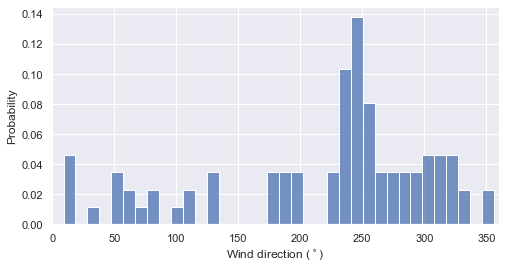

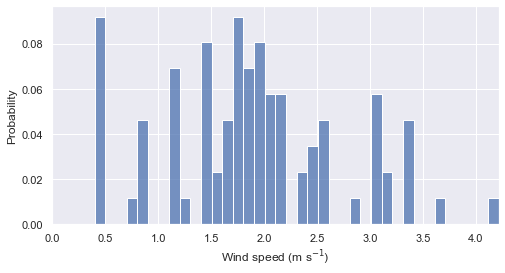

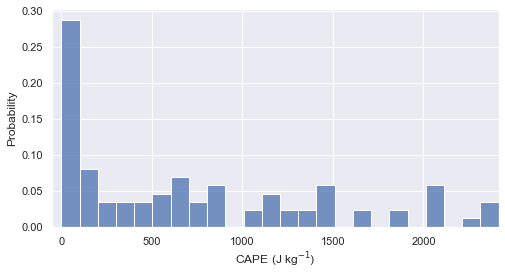

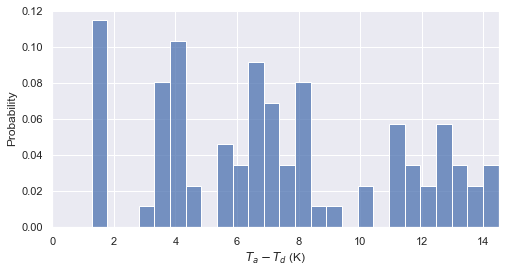

In [101]:
# WIND DIRECTION
plt.figure(figsize=(8,4))
seaborn.histplot(cellsmeteo.winddir, kde = False, stat = 'probability', bins = 36)
plt.xlabel('Wind direction ($^\circ$)')
#plt.ylabel('Density')
plt.xlim(0,360)
plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/surface_tINIT_wind_direction_'+nwp+'.png',dpi=400,facecolor='white',transparent=False)

# WIND SPEED
plt.figure(figsize=(8,4))
seaborn.histplot(cellsmeteo.windspeed/3.6, kde = False, stat = 'probability', bins = int(((cellsmeteo.windspeed/3.6).max()-(cellsmeteo.windspeed/3.6).min())/0.1))
plt.xlabel('Wind speed (m s$^{-1}$)')
#plt.ylabel('Density')
plt.xlim(0,(cellsmeteo.windspeed/3.6).max())
plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/surface_tINIT_wind_speed_'+nwp+'.png',dpi=400,facecolor='white',transparent=False)

# CAPE
plt.figure(figsize=(8,4))
seaborn.histplot(cellsmeteo.CAPE, kde = False, stat = 'probability', bins = int(((cellsmeteo.CAPE).max()-(cellsmeteo.CAPE).min())/100))
plt.xlabel('CAPE (J kg$^{-1}$)')
#plt.ylabel('Density')
plt.xlim(-50,cellsmeteo.CAPE.max())
plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/surface_tINIT_cape_'+nwp+'.png',dpi=400,facecolor='white',transparent=False)

# SPREAD
cellsmeteo['spread'] = cellsmeteo.temperature-cellsmeteo.dewpoint
plt.figure(figsize=(8,4))
seaborn.histplot(cellsmeteo.spread, kde = False, stat = 'probability', bins = int(((cellsmeteo.spread).max()-(cellsmeteo.spread).min())/0.5))
plt.xlabel('$T_{a} - T_{d}$ (K)')
#plt.ylabel('Density')
plt.xlim(0,cellsmeteo.spread.max())
plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/surface_tINIT_spread_'+nwp+'.png',dpi=400,facecolor='white',transparent=False)

In [118]:
cellsmeteo_all = pd.read_csv("/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/data/track_statistic_surface.csv")
cellsmeteo_ini = pd.read_csv("/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/tracks/data/track_statistic_surface_initial.csv")

In [145]:
cellsmeteo_ini

,timestr,cell,temperature,dewpoint,CAPE,winddir,windspeed,spread
0,2021-06-01 13:05:04,1,22.719999,9.25,16.0,323.130127,9.000000,13.469999
1,2021-06-01 13:09:20,1,22.719999,9.25,16.0,323.130127,9.000000,13.469999
2,2021-06-01 13:13:36,1,22.680000,9.12,32.0,319.184937,10.464797,13.560000
3,2021-06-02 10:59:12,1,22.660000,9.96,0.0,125.537674,6.193674,12.700000
4,2021-06-02 11:05:36,1,22.660000,9.96,0.0,125.537674,6.193674,12.700000
...,...,...,...,...,...,...,...,...
82,2021-07-26 10:10:08,1,20.240000,16.27,1883.0,333.434967,1.609969,3.969999
83,2021-07-26 10:14:24,1,20.240000,16.27,1883.0,333.434967,1.609969,3.969999
84,2021-07-26 09:10:24,2,18.270000,14.51,683.0,250.016907,8.427383,3.760000
85,2021-07-26 09:14:40,2,18.270000,14.51,683.0,250.016907,8.427383,3.760000
